<a href="https://colab.research.google.com/github/juwetta/DLI_Group-B/blob/main/Ivan_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Change directory to the desired location in Google Drive
import os
os.chdir('/content/gdrive/MyDrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


--2025-08-22 09:47:45--  https://raw.githubusercontent.com/juwetta/DLI_Group-B/main/URL_dataset_clean_balanced.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15312637 (15M) [text/plain]
Saving to: ‘URL_dataset_clean_balanced.csv’

URL_dataset_clean_b 100%[===================>]  14.60M  --.-KB/s    in 0.1s    

2025-08-22 09:47:46 (124 MB/s) - ‘URL_dataset_clean_balanced.csv’ saved [15312637/15312637]

✅ Dataset loaded successfully!
Shape: (208876, 2)
Columns: ['url', 'type']
                                                 url        type
0                               http://kitegacc.net/    phishing
1  https://www.electronichouse.com/article/ps3_ad...  legitimate
2      https://www.linkedin.com/in/larrymartinkimpel  legitimate
3  https://www.kansasci

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Classification Report:

+----------------+----------+-----------+--------+----------+---------+-------------------------+---------------+
|     Model      | Accuracy | Precision | Recall | F1 Score | ROC-AUC |         Params          | Inference(ms) |
+----------------+----------+-----------+--------+----------+---------+-------------------------+---------------+
| LGBMClassifier |  0.997   |   0.999   | 0.996  |  0.997   |  0.999  | trees=300, max_depth=-1 |     0.028     |
+----------------+----------+-----------+--------+----------+---------+-------------------------+---------------+


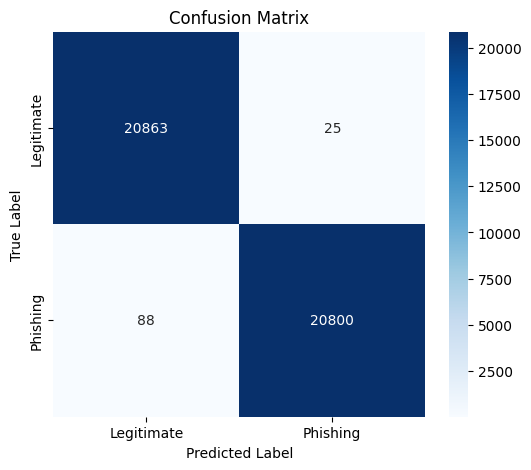

In [4]:
# =========================================================
# STEP 1: Install Required Packages (uncomment if needed)
# =========================================================
!pip install lightgbm optuna scikit-learn pandas numpy seaborn matplotlib

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, precision_score, recall_score
)
from lightgbm import LGBMClassifier

# =========================================================
# STEP 2: Load Dataset
# =========================================================
DATA_URL = "https://raw.githubusercontent.com/juwetta/DLI_Group-B/main/URL_dataset_clean_balanced.csv"
!wget -O URL_dataset_clean_balanced.csv "$DATA_URL"

df = pd.read_csv("URL_dataset_clean_balanced.csv")
print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# =========================================================
# STEP 3: Preprocess Data
# =========================================================
X = df["url"]
y = df["type"].map({"legitimate": 0, "phishing": 1})  # Encode labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# =========================================================
# STEP 4: Train LightGBM Model
# =========================================================
model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
model.fit(X_train_vec, y_train)
train_time = time.time() - start_time
print(f"⏱ Training completed in {train_time:.2f} seconds")

# =========================================================
# STEP 5: Summary Table
# =========================================================
# Inference time per sample
start_time = time.time()
y_pred = model.predict(X_test_vec)
inference_time = (time.time() - start_time) / len(X_test) * 1000  # ms/sample

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1])

# Classification Report
def _ascii_table(headers, rows):
    widths = [max(len(str(x)) for x in col) for col in zip(*([headers] + rows))]

    def fmt(text, width, center=False):
        text = str(text)
        pad = width - len(text)
        if center:
            left = pad // 2
            right = pad - left
            return ' ' * (left + 1) + text + ' ' * (right + 1)
        else:
            return ' ' + text + ' ' * (pad + 1)

    def line():
        return '+' + '+'.join('-' * (w + 2) for w in widths) + '+'

    out = [line(),
           '|' + '|'.join(fmt(h, w, center=True) for h, w in zip(headers, widths)) + '|',
           line()]
    for r in rows:
        out.append('|' + '|'.join(fmt(c, w, center=True) for c, w in zip(r, widths)) + '|')
    out.append(line())
    return '\n'.join(out)

# Build cells from your existing variables
model_label = type(model).__name__
trees = getattr(model, "n_estimators", None)
max_depth = getattr(model, "max_depth", None)
param_parts = []
if trees is not None: param_parts.append(f"trees={trees}")
if max_depth is not None: param_parts.append(f"max_depth={max_depth}")
params_str = ", ".join(param_parts) if param_parts else "—"

headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC", "Params", "Inference(ms)"]
row = [
    model_label,
    f"{accuracy:.3f}",
    f"{precision:.3f}",
    f"{recall:.3f}",
    f"{f1:.3f}",
    f"{roc_auc:.3f}",
    params_str,
    f"{inference_time:.3f}",
]

print("\nClassification Report:\n")
print(_ascii_table(headers, [row]))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legitimate", "Phishing"],
            yticklabels=["Legitimate", "Phishing"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()